# Bin cross-slope transects of atmospheric forcing and sea ice concentration into depth space

This script interpolates 2d data into an ASC coordinate system.

Things to note:
- The information on the orientation of the cross-slope transects, that is the lat and lon locations, are calculated in `Select_transects_630m_2000m.ipynb`.
- This script interpolates a monthly climatology of surface momentum stress (u and v) onto cross-slope transects AND bins them.
- Same for sea ice concentration. 

At the end of this script, existing files that where transformed into the new ASC coordinates system are loaded and nans removed.

### First, load in python modules

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors
from scipy.interpolate import griddata
from datetime import timedelta

# For metpy function
# (use the conda3 unstable kernel)
from metpy.interpolate import cross_section
#from metpy.interpolate import interpolate_to_slice

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [7]:
client = Client() # n_workers=4
client

Client Scheduler: tcp://127.0.0.1:33833 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 32.00 GiB


Nominate a database from wich to load the data and define an experiment

In [8]:
# Load database
session = cc.database.create_session()
# Define experiment in database
# RYF:
#expt = '01deg_jra55v13_ryf9091'
# IAF:
expt = '01deg_jra55v140_iaf_cycle3'

### Load data

In [9]:
lat_slice = slice(-80, -58)

# RYF
# start_time = '2080-01-01'
# end_time   = '2089-12-31'
# IAF
start_time = '1985-01-01' 
end_time   = '1994-12-31' 

Load transect information calculated in `Select_transects_630m_2000m.ipynb`

In [10]:
out_path = '/g/data/x77/wgh581/Post_Process/'
infile = out_path + 'Antarctic_slope_transects_630m_2000m.npz'
data = np.load(infile)
lat_shelf = data['lat_630m']
lon_shelf = data['lon_630m']
lat_deep  = data['lat_2000m']
lon_deep  = data['lon_2000m']

Load bathymetry

In [11]:
# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)  
hu = hu.load()

ht = cc.querying.getvar(expt, 'ht', session, n=1)
#ht = ht.sel(yt_ocean=lat_slice)  
ht = ht.load()

# lat/lon information
xu_ocean = hu.xu_ocean.values
yu_ocean = hu.yu_ocean.values

In [12]:
# Get rid of the curvliniear coordinates
# Add the drop command for RYF run, not required for IAF cycle 3
ht = ht.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})#.drop(['geolon_t', 'geolat_t'])

Load atmospheric surface momentum stress

In [16]:
# Total ocean momentum stress at surface
tau_x = cc.querying.getvar(expt, 'tau_x', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
tau_y = cc.querying.getvar(expt, 'tau_y', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
tau_x = tau_x.sel(yu_ocean=lat_slice).sel(time=slice(start_time, end_time))
tau_y = tau_y.sel(yu_ocean=lat_slice).sel(time=slice(start_time, end_time))

Monthly climatology

In [17]:
tau_x = tau_x.groupby('time.month').mean('time')
tau_y = tau_y.groupby('time.month').mean('time')

We want the 'along-slope' and 'cross-slope' velocity components

In [18]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [19]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

In [20]:
# Along-slope component
tau_x = tau_x*dhu_dy/slope - tau_y*dhu_dx/slope
# Cross-slope component
tau_y = tau_x*dhu_dx/slope + tau_y*dhu_dy/slope

Sea ice concentration

In [24]:
aice = cc.querying.getvar(expt, 'aice_m', session, start_time=start_time, end_time=end_time, frequency='1 monthly', decode_coords=False)
aice = aice.sel(time=slice(start_time, end_time))#.drop(['TLON', 'TLAT', 'ULON', 'ULAT'])
aice = aice.rename({'nj': 'lat', 'ni':'lon'})
aice = aice.assign_coords({'lon': ht.lon, 'lat': ht.lat}).sel(lat=lat_slice)
aice['time'] = aice.time - timedelta(hours=12)
aice = aice.groupby('time.month').mean('time')
#aice

Prepare data to interpolate to cross-section

$\tau_x$

In [21]:
# Create dataset
ds_tau_x = xr.Dataset({"tau_x": tau_x, "lat": tau_x.yu_ocean, "lon": tau_x.xu_ocean, "hu": hu})
# Rename coordinate names
ds_tau_x = ds_tau_x.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_tau_x['x']       = ds_tau_x['x']+100
ds_tau_x['x'].attrs = tau_x['xu_ocean'].attrs
# MetPy parsing
tau_x_parsed = ds_tau_x.metpy.parse_cf('tau_x', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


$\tau_y$

In [22]:
# Create dataset
ds_tau_y = xr.Dataset({"tau_y": tau_y, "lat": tau_y.yu_ocean, "lon": tau_y.xu_ocean, "hu": hu})
# Rename coordinate names
ds_tau_y = ds_tau_y.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_tau_y['x']       = ds_tau_y['x']+100
ds_tau_y['x'].attrs = tau_y['xu_ocean'].attrs
# MetPy parsing
tau_y_parsed = ds_tau_y.metpy.parse_cf('tau_y', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


hu

In [23]:
ds_hu = xr.Dataset({"hu": hu})
ds_hu = ds_hu.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
ds_hu['x'] = ds_hu['x']+100
ds_hu['x'].attrs = hu['xu_ocean'].attrs
hu_parsed  = ds_hu.metpy.parse_cf('hu', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


Sea ice concentration (a little problematic because aice is on T-grid whereas the transects are on the U-grid)

In [17]:
# Create dataset
ds_aice = xr.Dataset({"aice": aice})#, "lat": ht.yt_ocean, "lon": ht.xt_ocean, "ht": ht})
# Rename coordinate names
#ds_aice = ds_aice.rename({'lon': 'x', 'lat': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_aice['lon']       = ds_aice['lon']+100
ds_aice['lon'].attrs = ht['lon'].attrs
# MetPy parsing
aice_parsed = ds_aice.metpy.parse_cf('aice', coordinates={'y': 'lat', 'x': 'lon'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


### Helper functions

In [24]:
def get_increment_info(hu_raw):
    sign_info = np.sign(np.diff(hu_raw))
    add_increment = np.zeros(len(hu_raw))
    for mm in range(len(sign_info)):
        if sign_info[mm] == 0:
            # We have a duplicate, change add_info to something != 0
            if mm == 0:
                add_increment[mm+1] = 1
            else:
                if sign_info[mm-1] > 0:
                    add_increment[mm+1] = 1
                elif sign_info[mm-1] < 0:
                    add_increment[mm+1] = -1
                elif sign_info[mm-1] == 0:
                    add_increment[mm+1] = add_increment[mm]
    return add_increment

In [25]:
def get_local_min_max(hu_raw):
    b = (np.diff(np.sign(np.diff(hu_raw))) > 0).nonzero()[0] + 1 # local minimum
    c = (np.diff(np.sign(np.diff(hu_raw))) < 0).nonzero()[0] + 1 # local maximum
    b = b.tolist()
    c = c.tolist()
    return b, c

### Main code to interpolate onto transects and bin in depth bins

In [17]:
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency='1 monthly', start_time=start_time, end_time=end_time)
u = u.sel(xu_ocean=0, method='nearest').sel(yu_ocean=-60, method='nearest').sel(time=start_time, method='nereast')
depth_avail = u.st_ocean.values
min_index   = np.argwhere(depth_avail > 600)[0][0]
max_index   = np.argwhere(depth_avail < 2200)[-1][0]
depth_bins_st_ocean = depth_avail[min_index:max_index]

Depth bins

In [18]:
np.diff(depth_bins_st_ocean)
depth_bins_double = []
for ii in range(len(depth_bins_st_ocean)-1):
    new = np.diff(depth_bins_st_ocean)[ii] / 2
    depth_bins_double.append(depth_bins_st_ocean[ii])
    depth_bins_double.append(depth_bins_st_ocean[ii]+new)
depth_bins_double.append(depth_bins_st_ocean[-1])

In [19]:
# 2d array with depth information, used later to set values deeper than depth bin to nan
depth_avail_2d = np.ones((len(depth_avail), len(depth_bins_double))) * np.nan
for ii in range(len(depth_bins_double)):
    depth_avail_tmp = np.where(depth_avail < depth_bins_double[ii], depth_avail, np.nan)
    depth_avail_2d[:,ii] = depth_avail_tmp    

This is where the binning for the velocity field is actually done:

- You need to change the input file of the parsed produt under 1
- Run the code incrementally going along the coastline. Save each segment, we will combine them later.

In [32]:
%%time
#count = 0
# Define various variables used below when looping through each transect.

max_depth = 2150#2010 # (st_ocean value deeper than target depth of 2000 m)
min_depth = 500#620  # (st_ocean value shallower than target depth of 650 m)
step_no   = 50   # Number of points on the transect that we interpolate the model grid onto

binned_product = np.ones((len(lat_shelf), 12, len(depth_bins_double))) * np.nan# 1e6
ii_val = []
for ii in range(len(lat_shelf)):
    # Looping through each transect
    #if (ii > 2600) and (ii <= 3000):
    #if ii == count_index_small[30]:
    if (ii >= 2500) and (ii < 4000):
        ii_val.append(ii)
        if not ii % 20:
            print('index:', ii)
        # 1 - Interpolate model grid bathymetry onto cross-slope transect, use method='nearest'
        hu_raw = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
        hu_raw = hu_raw.values
        hu_raw_orig = hu_raw.copy() # Making a copy to compare change to original data
        # Also interpolate the atm forcing onto the cross-slope transects, use method='nearest'
        # CHANGE INPUT FILE OF PARSED PRODUCT
        # ONE OF: tau_x, tau_y, aice
        tau_raw = cross_section(tau_x_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
        
        # 2 - Skip head/tail
        # Set all values deeper than max_depth to the last value (skip tail)
        if np.any(hu_raw > max_depth) == True:
            index_max_depth = np.argwhere(hu_raw > max_depth)[0][0]
            hu_raw = hu_raw[:index_max_depth]
            tau_raw  = tau_raw[:,:index_max_depth]
        # Set all values shallower than min_depth to the next value (skip head)
        if np.any(hu_raw < min_depth) == True:
            index_min_depth = np.argwhere(hu_raw < min_depth)[-1][0]
            hu_raw = hu_raw[index_min_depth+1:]
            tau_raw  = tau_raw[:,index_min_depth+1:]

        if len(hu_raw) == 0:
            print('hu_raw was empty after skipping head/tail for index ', ii)
            binned_product[ii,:,:] = np.nan
            continue
            
        # 3 - Ignore transects where the first value is too deep (some transects have nan at the beginning, get rid of the nans first)
        if np.isnan(hu_raw[0]) == True:
            tau_raw  = tau_raw[:,~np.isnan(hu_raw)]
            hu_raw = hu_raw[~np.isnan(hu_raw)]
            if len(hu_raw) == 0:
                #count_index_too_deep.append(ii)
                binned_product[ii,:,:] = np.nan
                continue
        if (hu_raw[0] > 1200):
            #count_index_too_deep.append(ii)
            binned_product[ii,:,:] = np.nan
            continue
        
        # 4 - Check the first time for monotonicity. If so, hu_raw is ready to be used for the depth binning process. 
        # The only thing we need to do is to get rid of duplicates.
        if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
            # Write out which transects didn't need any smoothing, flattening, etc...
            #count_index_ready.append(ii)
            # Get rid of any duplicates to make sure hu_raw is monotonically increasing:
            if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var   = hu_raw[index]
                    hu_raw[index] = var + 0.001 * (ll+1)
                del index_duplicate, index, var

        else:
            # 5 - Smoothing of small variability
            increment = 30 # in meter, smaller than the smallest change in the depth bins used later
            if np.any( np.abs(np.diff(hu_raw)) < increment) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < increment)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var = hu_raw[index-1]
                    hu_raw[index] = var
                del index_duplicate, index, var

            # Again, make sure that no value is duplicated. This is to make it easier to select local minima and local maxima. 
            # This code differes slightly from the code above and below to change get rid of duplications, 
            # because here, we need hu_raw to increase and decrese depending on which side of a potentially existing bump we are.
            add_increment = get_increment_info(hu_raw)
            for ll in range(len(add_increment)):
                var = hu_raw[ll]
                if add_increment[ll] > 0:
                    hu_raw[ll] = var + (0.001*ll)
                elif add_increment[ll] < 0:
                    hu_raw[ll] = var - (0.001*ll)
            del add_increment, var
            
            # Check if smoothing alone helped to achieve monotonicity   
            if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                if np.all( np.sign(np.diff(hu_raw)) == 0) == True:
                    print('Index %i still has duplicates, this needs to be fixed!'%ii)
               
            else: 
                # 6 - The remaining transects should have a bump (in other words, b and c below shouldn't be both empty)
            
                # Sanity check for local minima and local maxima
                b, c = get_local_min_max(hu_raw)
                if (len(b)==0) and (len(c)==0):
                    print('Problem: b, c are zero for index ', ii)
                
                # Skip the tail if the local maximum is deeper than the last value
                if (len(c)>0):
                    index_tmp = np.argmax(hu_raw[c])
                    if hu_raw[c[index_tmp]] > hu_raw[-1]:
                        hu_raw = hu_raw[:c[index_tmp]+1]
                        tau_raw  = tau_raw[:,:c[index_tmp]+1]
                        # Calculate local min/max again
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                # Skip the head if the local minimum is shallower than the first value
                if (len(b)>0):
                    index_tmp = np.argmin(hu_raw[b])
                    if hu_raw[b[index_tmp]] < hu_raw[0]:
                        #print('entered loop')
                        hu_raw = hu_raw[b[index_tmp]:]
                        tau_raw  = tau_raw[:,b[index_tmp]:]
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                    
                # 7 - Now check for local minima and maxima
                if (len(b) == 0) and (len(c) == 0):
                    # Might exist if we skipped tail/head
                    delta_h = None
                elif (len(b) == 1) and (len(c) == 1):
                    # Only one bump exists
                    index_delta_h = 0
                    delta_h = hu_raw[c[index_delta_h]] - hu_raw[b[index_delta_h]]
                elif (len(b) > 1) and (len(c) > 1):
                    # Multiple bumps exist, we are interested in the largest to classify the transect
                    index_length = np.min([len(b), len(c)])
                    delta_h = hu_raw[c[:index_length]] - hu_raw[b[:index_length]]
                    index_delta_h = np.argmax(delta_h)
                    delta_h = np.max(delta_h)
                    del index_length
                elif (len(b)==1) and (len(c)!=1):
                    print('Only one minimum left, index ', ii)
                    delta_h = None
                elif (len(b)!=1) and (len(c)==1):
                    print('Only one maximum left, index ', ii)
                    delta_h = None

                # Classify into small or large bump transects
                if delta_h != None:
                    # Only look at cases where we have bumps
                    if delta_h < 0:
                        # Sanity check for any negative delta_h. This would mean the local minimum and maximum used to calculate delta_h originates from different bumps
                        print('Negative delta for index ', ii)
                    elif delta_h > 200:
                        # 7.1 Big bumps
                        binned_product[ii,:,:] = np.nan
                        continue
                    elif (delta_h > 0) and (delta_h <= 200):
                        # 7.2 Small bumps
                        # Now, this is where the real joy begins...
                        #count_index_small.append(ii)
                        #delta_h_index_small.append(delta_h)
                        if hu_raw[c[index_delta_h]] == np.max(hu_raw):
                            # 7.2.1 Skip the tail if the local minimum is the deepest value. 
                            hu_raw = hu_raw[:c[index_delta_h]+1]
                            print('Case 5.3.1 for index ', ii)
                            del index_delta_h
                        else:
                            # 7.2.2 Flatten hu_raw for the remaining transects
                            # Find the depth of the first local maximum (a trough)
                            if len(b) != len(c):
                                print('Number of minima and maxima not equal for index ', ii)
                            else:
                                for mm in range(len(b)):
                                    hu_tmp = hu_raw[c[mm]]
                                    hu_tmp_next_index = np.argwhere(hu_raw[c[mm]:] > hu_tmp)[0][0]
                                    hu_raw[c[mm]:c[mm]+hu_tmp_next_index] = hu_raw[c[mm]]
                                    # Again, make sure bathymetry differs for each point
                                    if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                                        # Find that index
                                        index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                                        for ll in range(np.size(index_duplicate[0])):
                                            index = index_duplicate[0][ll] + 1
                                            var   = hu_raw[index]#.values
                                            hu_raw[index] = var + 0.001 * (ll+1)
                                        del index_duplicate, index, var

        # One last sanity check: hu_raw should (finally!) have a monotonic increase for all transects:
        if np.any(np.diff(hu_raw) < 0) == True:
            print('Last sanity check, problem with index ', ii) 
        # And if there are any duplicates
        if np.any(np.diff(hu_raw)) == 0:
            print('Last sanity check, problem with duplicates for index ', ii)

        # Now, let's do the binning to depth space for the remaining transects
        # Replace 'index' dimension by bathymetry value at that point 
        tau_raw = tau_raw.rename({'index': 'hu'})
        tau_raw['hu'] = hu_raw
        # Interpolate to gridded bathymetry value
        #section_binned_linear  = tau_raw.interp(hu=depth_bins_double, kwargs={"fill_value": "extrapolate"}, method='linear')
        section_binned_nearest = tau_raw.interp(hu=depth_bins_double, kwargs={"fill_value": "extrapolate"}, method='nearest')
        # Replace nans near the bottom with nearest value
        #section_binned = section_binned_linear.where(np.isnan(section_binned_linear)==False, section_binned_nearest)
        # Set values deeper than depth_bins_double to nan (due to the nearest method we sometimes get values deeper than the desired bin)
        #section_binned = section_binned.where(np.isnan(depth_avail_2d)== False, np.nan)
        # Finished
        binned_product[ii,:,:] = section_binned_nearest.values#section_binned.values

save_dir = '/g/data/x77/wgh581/Post_Process/'
#outfile = 'binned_product_monthly.npz'
outfile = 'binned_product_monthly_tau_x_IAF_2500_4000.npz'
np.savez(save_dir + outfile, binned_product=binned_product)
print('Done.')

index: 2500
index: 2520
index: 2540
index: 2560
index: 2580
index: 2600
index: 2620
index: 2640
index: 2660
index: 2680
index: 2700
index: 2720
index: 2740
index: 2760
index: 2780
index: 2800
index: 2820
index: 2840
index: 2860
index: 2880
index: 2900
index: 2920
index: 2940
index: 2960
index: 2980
index: 3000
index: 3020
index: 3040
index: 3060
index: 3080
index: 3100
index: 3120
index: 3140
index: 3160
index: 3180
index: 3200
index: 3220
index: 3240
index: 3260
index: 3280
index: 3300
index: 3320
index: 3340
index: 3360
index: 3380
index: 3400
index: 3420
index: 3440
index: 3460
index: 3480
index: 3500
Done.
CPU times: user 17min 34s, sys: 1min 39s, total: 19min 14s
Wall time: 29min 4s


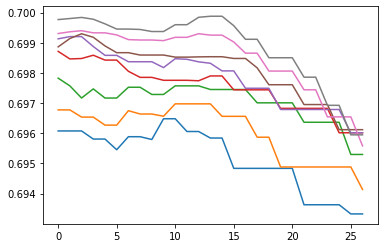

In [76]:
fig = plt.figure()
for tt in range(8):
    plt.plot(binned_product[900+tt,:,:].mean(axis=0))  # 5, 8
#for tt in range(12):
#    plt.plot(tau_raw[tt,:])

---

Once you ran the script for all segments, combine the saved data. The following combines the outputted data and saves them as a single `*.nc` file. The `*.npz` files can be deleted after this step. 

In [2]:
save_dir = '/g/data/x77/wgh581/Post_Process/'

In [4]:
data  = np.load(save_dir + 'binned_product_monthly_tau_x_IAF_0_500.npz')
data1 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_x_IAF_500_1500.npz')
data2 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_x_IAF_1500_2500.npz')
data3 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_x_IAF_2500_4000.npz')
data4 = data['binned_product']

In [5]:
binned_product_monthly_tau_x = data1
binned_product_monthly_tau_x[500:1500,:,:]  = data2[500:1500,:,:]
binned_product_monthly_tau_x[1500:2500,:,:] = data3[1500:2500,:,:]
binned_product_monthly_tau_x[2500:,:,:] = data4[2500:,:,:]

In [20]:
# Save as a *.nc file
# Create DataArray first
da_save = xr.DataArray(data=binned_product_monthly_tau_x, dims=["lon_shelf","month","depth_bin"],
                      coords=dict(lon_shelf=lon_shelf, month=np.arange(0, 12, 1), depth_bin=depth_bins_double),
                      attrs=dict(description="Binned product, tau_x", units="N/m2"))
# Then DataSet
ds_save = xr.Dataset({"tau_x_binned":da_save})
# Drop nans (missing transects)
#ds_save = ds_save.dropna('lon_shelf')
# Now save DataSet
ds_save.to_netcdf(save_dir+'binned_product_monthly_tau_along_IAF.nc')

Repeat for $\tau_y$

In [100]:
data  = np.load(save_dir + 'binned_product_monthly_tau_y_0_1000.npz')
data1 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_y_1000_1450.npz')
data2 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_y_1400_2000.npz')
data3 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_y_2000_3000.npz')
data4 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_tau_y_3000_end.npz')
data5 = data['binned_product']

In [101]:
binned_product_monthly_tau_y = data1
binned_product_monthly_tau_y[1000:1450,:,:] = data2[1000:1450,:,:]
binned_product_monthly_tau_y[1400:2000,:,:] = data3[1400:2000,:,:]
binned_product_monthly_tau_y[2000:3000,:,:] = data4[2000:3000,:,:]
binned_product_monthly_tau_y[3000:,:,:] = data5[3000:,:,:]

In [102]:
# Save as a *.nc file
# Create DataArray first
da_save = xr.DataArray(data=binned_product_monthly_tau_y, dims=["lon_shelf","month","depth_bin"],
                      coords=dict(lon_shelf=lon_shelf, month=np.arange(0, 12, 1), depth_bin=depth_bins_double),
                      attrs=dict(description="Binned product, tau_y", units="N/m2"))
# Then DataSet
ds_save = xr.Dataset({"tau_y_binned":da_save})
# Drop nans (missing transects)
#ds_save = ds_save.dropna('lon_shelf')
# Now save DataSet
ds_save.to_netcdf(save_dir+'binned_product_monthly_tau_cross.nc')

Repeat for aice

In [82]:
data  = np.load(save_dir + 'binned_product_monthly_aice_0_1000.npz')
data1 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_aice_1000_2000.npz')
data2 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_aice_2000_3000.npz')
data3 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_aice_3000_end.npz')
data4 = data['binned_product']

In [83]:
binned_product_monthly_aice = data1
binned_product_monthly_aice[1000:2000,:,:] = data2[1000:2000,:,:]
binned_product_monthly_aice[2000:3000,:,:] = data3[2000:3000,:,:]
binned_product_monthly_aice[3000:,:,:]     = data4[3000:,:,:]

In [84]:
# Save as a *.nc file
# Create DataArray first
da_save = xr.DataArray(data=binned_product_monthly_aice, dims=["lon_shelf","month","depth_bin"],
                      coords=dict(lon_shelf=lon_shelf, month=np.arange(0, 12, 1), depth_bin=depth_bins_double),
                      attrs=dict(description="Binned product, aice", units="1"))
# Then DataSet
ds_save = xr.Dataset({"aice_binned":da_save})
# Now save DataSet
ds_save.to_netcdf(save_dir+'binned_product_monthly_aice.nc')

---

Testing

(-0.5, 0.5)

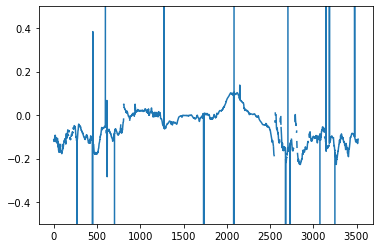

In [14]:
fig = plt.figure()
plt.plot(binned_product_monthly_tau_x[:,10,:].mean(axis=1))
plt.ylim(-0.5, 0.5)

(-0.5, 0.5)

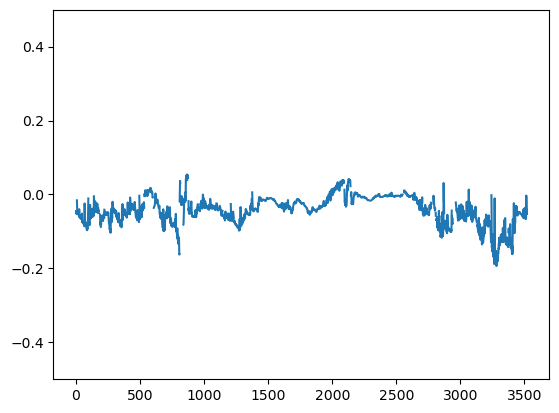

In [22]:
fig = plt.figure()
plt.plot(ds_save.tau_x_binned[:,11,:].mean(axis=1))
plt.ylim(-0.5, 0.5)

---
---

Drop nans for all datasets:

$\tau$_x and $\tau$_y

In [23]:
# Load *.nc file
ds = xr.open_dataset(save_dir + 'binned_product_monthly_tau_along_IAF.nc')
# Drop nans
ds = ds.dropna('lon_shelf')
# Save again
#ds.to_netcdf(save_dir + 'binned_product_monthly_tau_along_IAF_dropna.nc')

In [ ]:
ds = xr.open_dataset(save_dir + 'binned_product_monthly_tau_y.nc')
ds = ds.dropna('lon_shelf')
ds.to_netcdf(save_dir + 'binned_product_monthly_tau_y_dropna.nc')

aice

In [88]:
ds = xr.open_dataset(save_dir + 'binned_product_monthly_aice.nc')
ds = ds.dropna('lon_shelf', how='all')
ds.to_netcdf(save_dir + 'binned_product_monthly_aice_dropna.nc')
ds

<xarray.Dataset>
Dimensions:      (depth_bin: 27, lon_shelf: 3273, month: 12)
Coordinates:
  * lon_shelf    (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * month        (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * depth_bin    (depth_bin) float64 630.7 663.1 695.4 ... 1.933e+03 2.007e+03
Data variables:
    aice_binned  (lon_shelf, month, depth_bin) float64 0.06551 ... 0.4104

u_along  
GIVES US DIFFERENT NO OF TRANSECTS THAN FOR ATM PRODUCT

In [15]:
ds = xr.open_dataset(save_dir + 'binned_product_monthly.nc')
ds['u_along_binned'] = ds['__xarray_dataarray_variable__']
ds = ds.drop(['__xarray_dataarray_variable__'])
ds = ds.dropna('lon_shelf', how='all')
ds.to_netcdf(save_dir + 'binned_product_monthly_dropna.nc')
ds

<xarray.Dataset>
Dimensions:         (depth_bin: 27, lon_shelf: 3264, month: 12, st_ocean: 75)
Coordinates:
  * lon_shelf       (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * depth_bin       (depth_bin) float64 630.7 663.1 ... 1.933e+03 2.007e+03
Data variables:
    u_along_binned  (lon_shelf, month, st_ocean, depth_bin) float64 -0.07002 ...

In [16]:
ds = xr.open_dataset(save_dir + 'transects_binned_daily_full.nc')
ds['u_along_binned'] = ds['__xarray_dataarray_variable__']
ds = ds.drop(['__xarray_dataarray_variable__'])
ds = ds.dropna('lon_shelf', how='all')
ds.to_netcdf(save_dir + 'transects_binned_daily_full_dropna.nc')
ds

<xarray.Dataset>
Dimensions:         (depth_bin: 27, lon_shelf: 3264, st_ocean: 54, time: 365)
Coordinates:
  * time            (time) object 2086-01-01 12:00:00 ... 2086-12-31 12:00:00
  * lon_shelf       (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
  * depth_bin       (depth_bin) float64 630.7 663.1 ... 1.933e+03 2.007e+03
Data variables:
    u_along_binned  (lon_shelf, time, st_ocean, depth_bin) float64 -0.05824 ....

(-0.2, 0.2)

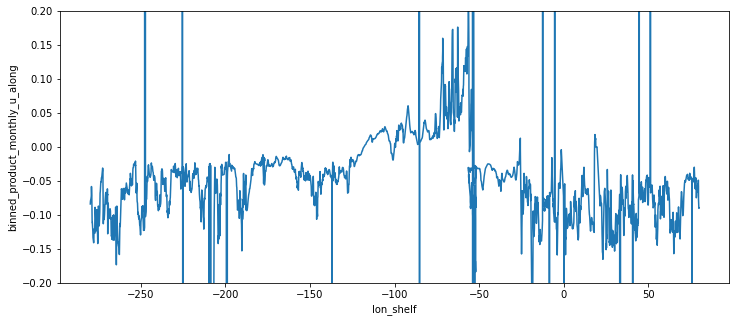

In [78]:
fig = plt.figure(figsize=(12,5))
ds = ds.dropna('lon_shelf', how='all')
ds.u_along_binned.mean('depth_bin').mean('month').mean('st_ocean').plot()
plt.ylim(-0.2, 0.2)

In [8]:
ds_aice = xr.open_dataset(save_dir + 'binned_product_monthly_aice.nc')
#ds_aice = ds_aice.dropna('lon_shelf', how='all')
ds_monthly = xr.open_dataset(save_dir + 'binned_product_monthly.nc')
ds_monthly['u_along_binned'] = ds_monthly['__xarray_dataarray_variable__']
ds_monthly = ds_monthly.drop(['__xarray_dataarray_variable__'])

In [9]:
ds_aice

<xarray.Dataset>
Dimensions:      (depth_bin: 27, lon_shelf: 3520, month: 12)
Coordinates:
  * lon_shelf    (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * month        (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * depth_bin    (depth_bin) float64 630.7 663.1 695.4 ... 1.933e+03 2.007e+03
Data variables:
    aice_binned  (lon_shelf, month, depth_bin) float64 ...

In [11]:
ds_monthly

<xarray.Dataset>
Dimensions:         (depth_bin: 27, lon_shelf: 3520, month: 12, st_ocean: 75)
Coordinates:
  * lon_shelf       (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * depth_bin       (depth_bin) float64 630.7 663.1 ... 1.933e+03 2.007e+03
Data variables:
    u_along_binned  (lon_shelf, month, st_ocean, depth_bin) float64 ...